In [1]:
import numpy as np
import xarray as xr
import glob as glob
import matplotlib.pyplot as plt
import cftime
import datetime as dt
import xesmf as xe

In [2]:
from dask.distributed import Client,LocalCluster
cluster = LocalCluster(n_workers=10, threads_per_worker=2) 
client = Client(cluster, asynchronous=True)  # start distributed scheduler locally.  Launch dashboard
client

/home/fiaz/anaconda3/envs/analysis_env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40897 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40897/status,
Dashboard: http://127.0.0.1:40897/status,Workers: 10
Total threads: 20,Total memory: 361.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41028,Workers: 10
Dashboard: http://127.0.0.1:40897/status,Total threads: 20
Started: Just now,Total memory: 361.35 GiB
Comm: tcp://127.0.0.1:34730,Total threads: 2
Dashboard: http://127.0.0.1:34916/status,Memory: 36.13 GiB
Nanny: tcp://127.0.0.1:42859,


In [3]:
## read nino3.4 index
READ_SAVE_NINO3_4=False
if READ_SAVE_NINO3_4:
    from indian_monsoon_analys import convert_nino34_indx_to_netcdf
    nino34_file='/neelin2020/Indian_Monsoon_files/nino34.long.anom.data'
    SAVE_FILE='/neelin2020/Indian_Monsoon_files/nino34_indx_monthly.nc'
    convert_nino34_indx_to_netcdf(nino34_file,SAVE_FILE)

In [4]:
## set paths to files 
main_file_path='/neelin2020/Indian_Monsoon_files/'
fil_rain=glob.glob(main_file_path+'imd_rain_daily_0p25_monsoon-masked_1901-2020.nc')[0]
fil_nino34=glob.glob(main_file_path+'nino34_noaa-ersst_monthly.nc')[0]

In [5]:
## generate list of era5 files
era5_file_path=main_file_path+'/ERA5/'
fils_era5=glob.glob(era5_file_path+'era-5_Tq_*grib')
fils_era5_idx=glob.glob(era5_file_path+'era-5_Tq_*idx')
fils_era5.sort()
fils_era5=[fil for fil in fils_era5 if fil not in fils_era5_idx]

In [6]:
## read land mask
land_mask=xr.open_dataset(fil_rain).land_mask

In [7]:
fil_cmz_mask_regridded='/neelin2020/Indian_Monsoon_files/cmz_mask_regridded.nc'
### regrid cmz mask if required
REGRID_SAVE_CMZ=False

if REGRID_SAVE_CMZ:
    fil_cmz_mask=glob.glob(main_file_path+'imd_0.25_CMZ_mask.nc')[0]
    from indian_monsoon_analys import regrid_cmz_mask
    cmz_mask=xr.open_dataset(fil_cmz_mask)
    ## read and regrid cmz mask if necessary
    cmz_mask_regridded=regrid_cmz_mask(cmz_mask,land_mask,fil_cmz_mask)
    cmz_mask.close()


In [207]:
## set era5 options
dir_out='/neelin2020/Indian_Monsoon_files/buoy_files/'
filter_surf_press=750
save_path='/neelin2020/Indian_Monsoon_files/processed_thermo/'

In [246]:
import indian_monsoon_analys
import importlib
importlib.reload(indian_monsoon_analys)
from indian_monsoon_analys import ProcessIMD, MaskIndianMonsoon,ProcessERA5

In [ ]:
for fil in fils_era5:
    date_str=fil.split('Tq_')[-1].split('.grib')[0]
    month=dt.datetime.strptime(date_str,'%Y_%m_%d').month
    if month in range(6,9): ## JJAS filter
        print(month)
        obj_era5=ProcessERA5(fil,dir_out,filter_surf_press,land_mask,fil_cmz_mask_regridded,save_path)
        obj_era5.main()
        break


6
wg


In [217]:
ds={}
for key in ['wg','sei','cmz']:
    ds[key]=xr.Dataset(data_vars=dict(thetae_bl=obj_era5.thetae_bl[key].unstack(),
                             thetae_lft=obj_era5.thetae_lft[key].unstack(),
                             thetae_sat_lft=obj_era5.thetae_sat_lft[key].unstack())).drop(['surface','lev'])




In [219]:
ds_new=xr.merge([ds[key] for key in ds.keys()],join='outer')

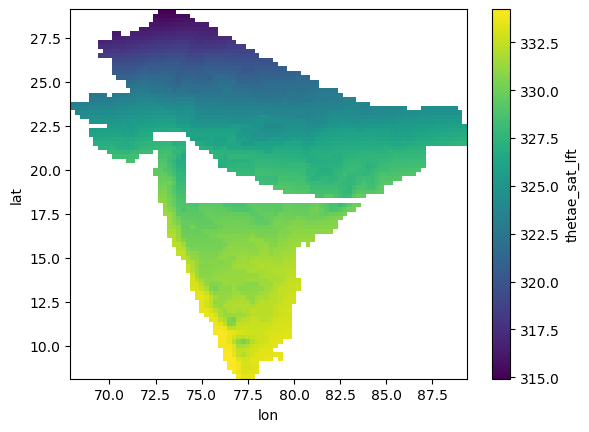

In [228]:
(ds_new.thetae_sat_lft).mean('time').plot()

In [229]:
ds_new.nbytes/pow(2,20)

3.9697418212890625

In [124]:
init_dict=lambda x: dict.fromkeys(['wg', 'cmz', 'sei'])
list1=[a=None,b=None]
from itertools import repeat
for i in list1:
    print(i)
    i=dict.fromkeys(['wg', 'cmz', 'sei'])

SyntaxError: invalid syntax (2613771759.py, line 3)

{'wg': None, 'cmz': None, 'sei': None}

In [107]:
init_dict(None)

{'wg': None, 'cmz': None, 'sei': None}

In [114]:
a['sei']=10
a,b

({'wg': None, 'cmz': None, 'sei': 10}, {'wg': None, 'cmz': None, 'sei': None})

In [ ]:
ret[0].where(cond_filter).dropna('z')

In [ ]:
obj_era5._ProcessERA5__filter_surf_press(ret[0],ret[1])

In [ ]:
obj_era5.cmz_mask.plot()

In [ ]:
regrid_cmz_mask(obj_era5.mask['cmz'],land_mask)

In [ ]:

obj_era5.mask['cmz'].lat.sel(lat=obj_era5.mask['wg'].lat,method='nearest')

In [ ]:
(obj_era5.q*obj_era5.cmz_mask)#.stack(z=('lat','lon')).reset_index('z').dropna('z').drop(['lat','lon'])

In [ ]:
# obj_era5.q*obj_era5.ghats_mask.stack(z=('lat','lon'))
(obj_era5.q*obj_era5.ghats_mask.drop_vars(['sfc_area','land_mask','monsoon_mask'])).stack(z=('lat','lon'))

In [ ]:
obj_era5.q

In [ ]:
imd_obj=ProcessIMD(fil_rain,land_mask,fil_cmz_mask)
imd_obj.mask_west_ghats()
imd_obj.mask_sei()

In [ ]:
fig,axx=plt.subplots(1,1,figsize=(3.,4))
ax=axx
imd_obj.ghats_mask.plot(ax=axx,cmap='Blues',alpha=0.5,add_colorbar=False )
imd_obj.sei_mask.plot(ax=axx,add_colorbar=False )
imd_obj.cmz_mask.plot(ax=axx,cmap='Oranges',alpha=0.5,add_colorbar=False )



In [ ]:
fils_era5[0]

In [ ]:
obj_era5=ProcessERA5(fils_era5[0],land_mask,fil_cmz_mask)

In [ ]:
obj_era5.ds_era5.nbytes/(pow(2,20))

In [ ]:
ds_rain.lat